In [1]:
# ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3L.h5

In [32]:
import random

import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [19]:
samples = pd.read_csv('samples.tsv', sep='\t')
print(samples['cross'].unique())
print(samples[samples['cross'] == 'cross-29-2'][['id', 'function']])

['cross-29-2' 'cross-36-9' 'cross-42-4' 'cross-46-9']
          id function
0   AD0231-C   parent
1   AD0232-C   parent
2   AD0234-C  progeny
3   AD0235-C  progeny
4   AD0236-C  progeny
5   AD0237-C  progeny
6   AD0238-C  progeny
7   AD0239-C  progeny
8   AD0240-C  progeny
9   AD0241-C  progeny
10  AD0242-C  progeny
11  AD0243-C  progeny
12  AD0244-C  progeny
13  AD0245-C  progeny
14  AD0246-C  progeny
15  AD0247-C  progeny
16  AD0248-C  progeny
17  AD0249-C  progeny
18  AD0250-C  progeny
19  AD0251-C  progeny
20  AD0252-C  progeny
21  AD0253-C  progeny


In [49]:
num_sims = 100000
num_ofs = 20
num_hets = []
for sim in range(num_sims):
    sim_hets = 0
    for ofs in range(20):
        sim_hets += 1 if sum(random.choices([0, 1], k=2)) == 1 else 0
    num_hets.append(sim_hets)

(array([0.0000e+00, 0.0000e+00, 1.3000e+01, 1.2700e+02, 4.7500e+02,
        1.5260e+03, 3.5810e+03, 7.4090e+03, 1.2085e+04, 1.6055e+04,
        1.7514e+04, 1.5910e+04, 1.2045e+04, 7.4760e+03, 3.7290e+03,
        1.4640e+03, 4.4800e+02, 1.1500e+02, 2.7000e+01]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

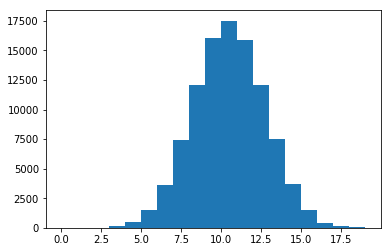

In [50]:
plt.hist(num_hets, bins=range(20))

In [52]:
[x for x in num_hets if x == 5]

[5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
